# Finetuned VAE for Embedding

Using a finetrained VAE for image embedding, into downstream UMAP.

*Aniket Pant, Personal*

In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import os
import numpy as np
from sklearn import preprocessing
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import umap

# Setting device for GPU usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [48]:
device

device(type='cuda')

# Operate with model for training

In [49]:
# Prepare Dataset
data_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    # transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

# Define indices
np.random.seed(42)
indices = np.random.choice(np.arange(81001), size=20_000, replace=False)

# Create ImageFolder and Subset
image_datasets = datasets.ImageFolder('./wikiart', data_transform)
subset_datasets = Subset(image_datasets, indices)

# Get filenames from the ImageFolder using Subset indices
filenames = [image_datasets.imgs[i][0] for i in subset_datasets.indices]

In [50]:
subset_datasets[0][1]

24

(-0.5, 255.5, 255.5, -0.5)

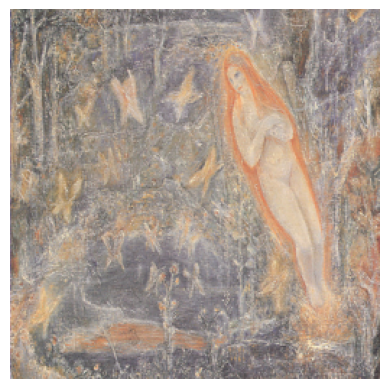

In [51]:
plt.imshow(subset_datasets[0][0].detach().cpu().numpy().transpose((1,2,0)))
plt.axis("off")

In [52]:
filenames[0]

'./wikiart/Symbolism/albert-bloch_metamorphosis-1948.jpg'

In [53]:
dataloaders = DataLoader(subset_datasets, batch_size=32, shuffle=True, num_workers=4)

In [54]:
dataset_sizes = len(subset_datasets)
print(dataset_sizes)

20000


In [55]:
# DEFINE MODEL FOR VAE
from vae import VAE, ConvVAE

latent_dim = 64

# model = VAE(latent_dim=latent_dim).to(device)
model = ConvVAE(latent_dim=latent_dim).to(device)

In [56]:
# model(next(iter(dataloaders))[0].cuda())

In [ ]:
def train_vae(vae, dataloader, optimizer, num_epochs):
    loss_history = []
    for epoch in range(num_epochs):
        for i, (inputs, _) in enumerate(dataloader):
            inputs = inputs.to(device)
            # Forward pass
            recon_batch, mu, logvar = vae(inputs)
            # Compute loss
            BCE = F.binary_cross_entropy(recon_batch, inputs, reduction='sum')
            KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = BCE + 10 * KLD
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_history.append(loss.item())
            
            if i % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                      .format(epoch+1, num_epochs, i+1, len(dataloader), loss.item()))

    return loss_history

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Assume dataloaders is your dataloader
loss_hist = train_vae(model, dataloaders, optimizer, num_epochs=20)

Epoch [1/20], Step [1/625], Loss: 4325524.5000
Epoch [1/20], Step [101/625], Loss: 3839617.2500
Epoch [1/20], Step [201/625], Loss: 3656331.2500
Epoch [1/20], Step [301/625], Loss: 3558600.0000
Epoch [1/20], Step [401/625], Loss: 3632937.2500


In [ ]:
plt.plot(loss_hist)

## Get embeddings

In [ ]:
def extract_vae_features(vae, loader):
    features = []
    labels = []

    with torch.no_grad():
        for i, (inputs, classes) in tqdm(enumerate(loader)):
            inputs = inputs.to(device)
            mu, logvar = vae.encode(inputs)  # Ensure inputs are flattened
            features.extend(mu.cpu().numpy())
            labels.extend(classes.cpu().numpy())
    return features, labels

In [ ]:
# Assume vae is your trained VAE model and dataloader is your DataLoader
features, labels = extract_vae_features(model, dataloaders)

In [71]:
# Use UMAP to reduce dimensionality
reducer = umap.UMAP(random_state = 42)
embedding = reducer.fit_transform(features)

In [72]:
def plot_embeddings(embeddings, labels):
    plt.figure(figsize=(6, 4))

    le = preprocessing.LabelEncoder()
    classes = le.fit_transform(labels)

    # Create a scatter plot
    plt.scatter(embeddings[:, 0], embeddings[:, 1], c = classes, s = 1, alpha = 0.3)

    plt.colorbar()
    plt.axis("off")
    plt.show()

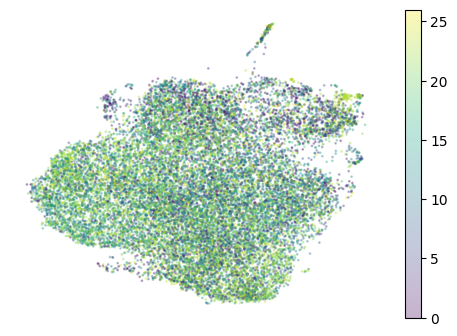

In [73]:
plot_embeddings(embedding, labels)

In [74]:
np.save("results/embeddings.npy", embedding)
np.save("results/filenames.npy", filenames)

In [75]:
filenames[0:2]

['./wikiart/Symbolism/albert-bloch_metamorphosis-1948.jpg',
 './wikiart/Impressionism/eugene-boudin_the-giudecca-from-the-zatteri-venice.jpg']